# Algorithm

Tentative strategic plan (to be verified in the backtesting algo):

1. Select only equitys which have not have negative earnings in the last 15 years.
2. Select only equitys with an equity ratio of >25%
3. Select RoE in the upper half of all (more than 60% or 70% depending on the outcome of the backtesting)
4. Reasonable earnings growth history
5. Optional point: price-book-ratio<1
6. P/E ratio not more than 10% above the min historical P/E ratio
7. P/E ratio (historical over past three years) < 20
8. Positive reaction to quartery report
9. [+1/0] if rating is negative/positive
10. EBT margin >12%

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time as tt

cnx        = sqlite3.connect('database/stocks_main.db')
xetra      = pd.read_sql("SELECT * FROM XETRA;", cnx)

In [213]:
def get_datetime(inputobj):
    return dt.datetime.date(inputobj)

def convert_sql_date_to_datetime_date(string):
    return dt.datetime.strptime(string,'%Y-%m-%d').date()

class quotes:
    def __init__(self):
        pass

    def _get_lastprice(self):
        self.lastquote = self.quote[self.quote.date==self.quote.date.max()].close.values
    
    def _get_quote(self):
        # load the entries for the current stock from the database
        cnx         = sqlite3.connect('database/stocks_quotes.db')
        sql         = pd.read_sql_query("SELECT * FROM quotes WHERE isin = '{0}';".format(self.isin), cnx)
        cnx.close()    
        if sql is not None:
            sql['date'] = sql.date.apply(convert_sql_date_to_datetime_date)
        self.quote  = sql
        
        self._get_lastprice()
        
    def get_highwatermark(self):
        '''Calculate the high watermark of the dataset'''
        hw = []
        mark = 0
        for i,j in self.quote.iterrows():
            if j['close']>mark and j['close']>0:
                mark = j['close']
            hw.append(mark)
        self.quote = self.quote.assign(highwatermark=pd.Series(hw))
        
class fundamentals:
    def __init__(self):
        pass

    def _get_keyratios(self):
        # load the entries for the current stock from the database
        cnx         = sqlite3.connect('database/stocks_keyratios.db')
        sql         = pd.read_sql_query("SELECT * FROM fundamentals WHERE ISIN = '{0}';".format(self.isin), cnx)
        cnx.close()    
        sql = sql.sort_values(by='year',ascending=False)
        sql = sql.reset_index(drop=True)
        
        self.keyratios = sql
        
    def _get_pe_for_year(self, pe_year, month=4, day=1, detailed=False):
        '''Get the price/earnings ratio for every day of the subsequent year'''
        # get the min/max date for selecting the quotes
        mindate = dt.date(pe_year+1, month, day)                                             
        maxdate = dt.date(pe_year+2, month, day)

        # get the eps for the year under consideration
        eps   = self.keyratios[self.keyratios.year==pe_year]['EarningsPerShare'].values[0]
        
        if eps is None:
            return None

        # extract the quote 
        quote = self.quote[(self.quote.date>mindate) & (self.quote.date<maxdate)]

        quote = quote.assign(pe=(quote.close/eps).values)
        quote = quote.assign(eps=np.ones(len(quote))*eps)

        if detailed:
            return quote
        return quote[['date','close','pe', 'eps']]
    
    def _get_all_pe(self,detailed=False):
        '''Creates an object with the price to earnings ratio for every day of all years'''
        
        # check if the currencies are the same; otherwise return None
        _quotecur    = self.quote['currency'].unique()
        _keyratiocur = self.keyratios['currency'].unique()
        if _quotecur != _keyratiocur:
            self._error_message('Quote and keyratio table not of the same currency')
            self.per_table = None
            return 
        
        # initialize the final dataframe
        finalquote = None

        # loop over the last 10 years
        for year in self.keyratios['year'][0:10]:
            if finalquote is None:
                finalquote = self._get_pe_for_year(year,detailed=detailed)
            else:
                finalquote = finalquote.append(self._get_pe_for_year(year,detailed=detailed),ignore_index=True)
            year+=1
        self.per_table = finalquote

In [285]:
class algo:
    def _initialize_algo(self):
        self.cols         = ['Name','ISIN', 'Parameter', 'Value', 'Point']
        self.quant_result = pd.DataFrame(columns=self.cols)
    
    def _add_result(self,para,val,point):
        '''Add the result of the individual analysis to the total result.'''
        res = [[self.name, self.isin, para, val, point]]
        self.quant_result = self.quant_result.append(pd.DataFrame(res,columns=self.cols),ignore_index=True)
    
    def get_best_column(self,*args):
        '''If multiple columns can be used for the analysis, select the column with the best data quality'''
        vals = args

        _length = []
        for _i, _s in enumerate(vals):
            _length.append([_i,len(self.keyratios[self.keyratios[_s].isnull()])])
        _length = np.array(_length)
        _bestcol = vals[_length[_length[:,1].argmin()][0]]

        return _bestcol
    
    def positive_earnings(self,verbose=False):
        
        _col = self.get_best_column('NetIncome','EarningsPerShare')
        if (self.keyratios[_col]<0).any():
            val   = -1
            point = -1
        else:
            val   = 1
            point = 1 
        self._add_result('OnlyPositiveEarnings', 0, point)
        
    
    def historic_roe(self):
        '''Checks if the historic ROE was never below 20%'''
        _roe = self.keyratios['ReturnonEquity'][1:]
        _roe = _roe[_roe>0]

        if not (_roe<20).any():
            point = 1
        elif not (_roe<10).any():
            point = 0
        else:
            point = -1
            
        _value = _roe.min()
        self._add_result('HistoricROE', '{0:0.1f}'.format(_value),  point)  
        
        
    def present_roe(self):
        '''Check if ROE is above 20%'''
        _roe = self.keyratios['ReturnonEquity']
        _val = _roe[0]

        if _val is None:
            self._add_result('PresentROE', '{0:0.1f}'.format(0), -1) 
            self._error_message('PresentROE is of type None')            
            return
        
        if not (_val<20).any():
            point = 1
        elif not (_val<10).any():
            point = 0
        else:
            point = -1
            
        self._add_result('PresentROE', '{0:0.1f}'.format(_val), point)  

        
    def present_ebtmargin(self):
        '''Check if EBT margin is above 12%'''
        _ebtm = self.keyratios['EBTMargin']
        _val  = _ebtm[0]
        
        if _val is None:
            self._add_result('EBTMargin', '{0:0.1f}'.format(0),  -1)
            self._error_message('EBTMargin is of type None')
            return

        if _val>12:
            point = 1
        elif _val<6:
            point = -1
        else:
            point = 0
            
        self._add_result('EBTMargin', '{0:0.1f}'.format(_val),  point)  
        
    def earnings_growth(self):
        '''Calculates the mean earnings growth over the last ten years'''
        _col                        =  self.get_best_column('NetIncome','EarningsPerShare')
        
        mean_earnings_old           =  self.keyratios[_col][8:11].mean()
        mean_earnings_new           =  self.keyratios[_col][0:3].mean()
        
        # check if mean_earnings_old not zero, to prevent ZeroDivisionError
        try:
            _mean_growth_all = (mean_earnings_new-mean_earnings_old)/mean_earnings_old
        except ZeroDivisionError:
            _mean_growth_all = -0.99
            
        _mean_growth_pa  = (1+_mean_growth_all)**(1./8.) 
        _mean_growth_pa  = _mean_growth_pa -1
        
        if type(_mean_growth_pa) is complex:
            _mean_growth_pa = _mean_growth_all/8.
        
        if _mean_growth_pa>0.05:
            point = 1
        elif _mean_growth_pa<0:
            point = -1
        else:
            point = 0
            
        self.mean_earnings_growth = _mean_growth_pa
        self._add_result('AnnualEarningsGrowth', '{0:0.1f}'.format(_mean_growth_pa*100), point)  
        
    def dividend_growth(self):
        '''Check if dividend has been growing over ten years'''
        _latest_div   = self.keyratios['Dividends'][0:3].mean()
        _previous_div = self.keyratios['Dividends'][8:11].mean()
        _div_growth = (_latest_div-_previous_div)/(_previous_div)

        if _div_growth<0.25:
            point = -1
        elif _div_growth>1.0:
            point = +1
        else:
            point = 0
        self._add_result('DividendGrowth', '{0:0.1f}'.format(_div_growth*100), point)  
        
        
    def equityratio(self):
        '''Check the equity ratio. So far the limits correspond to non-financial assets.'''
        equity_ratio = self.keyratios['TotalStockholdersEquity'][0]
        
        if equity_ratio<15.:
            point = -1
        elif equity_ratio>25.:
            point = 1
        else:
            point = 0
        self._add_result('EquityRatio', '{0:0.1f}'.format(equity_ratio), point)  
        
    def _no_fundamentals(self):
        '''Check if the fundmentals dataframe is empty'''
        if len(self.keyratios)==0:
            self._error_message("No fundamentals found.")
            return True
        return False
    
    def get_summary(self,save=False):
        if self._no_fundamentals():
            return
        
        self.positive_earnings()
        self.earnings_growth()
        self.historic_roe()
        self.present_roe()
        self.equityratio()
        self.present_ebtmargin()
        self.dividend_growth()
        self.get_fair_price()
        self._get_all_pe()
        self.get_fair_price_from_pe()
        
        self.summary = pd.DataFrame([[self.name, 
                                       self.isin,
                                       self.fairprice,
                                       self.fairprice_pe,
                                       self.price,
                                       self.quant_result['Point'].sum()
                                     ]],columns=['Name','ISIN','FairPrice','FairPricePE', 'Price', 'Points'])
        
        if save:
            out_conn        = sqlite3.connect('output/algo_results.db')
            self.quant_result.to_sql('results',out_conn, if_exists='append',index=False)
            
            self.summary.to_sql('summary',out_conn, if_exists='append',index=False)
        
        self._log_message('Completed get_summary')
        
        
# ratios related to stock price

    def _fair_price(self,holdduration=10, interest=0.02, growth = None):
        '''Calculate the lower and the upper bound '''
        
        last_eps = self.keyratios['EarningsPerShare'][0:3].mean()
        bookval  = self.keyratios['BookValuePerShare'][0]
        if growth is None:
            growth        = self.mean_earnings_growth
        
        if bookval is None:
            bookval = 0

        fairprice = 0
        for y in range(0,holdduration):
            fairprice+=(1.+growth)**y*last_eps/(1.+interest)**y
        fairprice +=bookval

        return fairprice

    def get_fair_price(self):
        _low_fair_price  = self._fair_price(holdduration=10,interest=0.02,growth=0.0)
        _high_fair_price = self._fair_price(holdduration=10,interest=0.02,growth=None)    
        _current_price   = self.quote[self.quote.date==self.quote.date.max()]['close'].values[0]
        
        _fairprice       = np.array([_low_fair_price, _high_fair_price]).mean()
        
        self.fairprice   = _fairprice
        self.price       = _current_price

    def get_fair_price_from_pe(self,quantile=0.5, marginofsafety=0.1):
        try:
            _pe_median   =  self.per_table['pe'].quantile(quantile)
        except TypeError:
            self._error_message('Cant read pe from per_table, fairprice_pe set to 0')
            self.fairprice_pe = 0
            return
            
        _scaled_median_price = _pe_median*self.keyratios['EarningsPerShare'][0]
        _fair_price          = _scaled_median_price*(1-marginofsafety)        
        self.fairprice_pe    = _fair_price
        
    def per_vs_historic_per(self,verbose=False):
        self._get_all_pe()
        
        _current = self.per_table[self.per_table.date == self.per_table.date.max()].pe.values[0]
        _limit1  = self.per_table.pe.quantile(0.33)
        _limit2  = self.per_table.pe.quantile(0.66)
            
        self._add_result('EPSvsHistoricEPS', 
                         '{0:0.1f}|{1:0.1f} - {2:0.1f}'.format(_limit1, _limit2, _current), 
                         point)

In [286]:
class logging:
    '''Error handling for the algoritm'''
    def _get_timestamp(self):
        ts = tt.time()
        return dt.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    def _error_message(self,message):
        ts = self._get_timestamp()
        text_file = open("output/algo.err", "a")
        text_file.write("{0}  {1}  {2:10s}\t{3}\n".format(ts, self.isin, self.name[0:10], message))
        text_file.close()
    def _log_message(self,message):
        ts = self._get_timestamp()
        text_file = open("output/algo.log", "a")
        text_file.write("{0}  {1}  {2:10s}\t{3}\n".format(ts, self.isin, self.name[0:10], message))
        text_file.close()        

In [287]:
class time:
    '''Make the analysis for today a special case of backtesting'''
    
    def _assign_pointintime(self, day):
        # self.bdate = the backtesting date
        self.day      = day
        self.bdate    = self.quote.date[0] + dt.timedelta(days=self.day)
        self.quote    = self.quote[self.quote.date < self.bdate]
        
        if self.bdate.month<4:
            _max_keyratio_year = self.bdate.year - 2 
        else:
            _max_keyratio_year = self.bdate.year - 1

        self.keyratios = self.keyratios[self.keyratios['year'] < _max_keyratio_year]

In [288]:
class plotting:
    '''Plot key quantities'''
    
    def plot_summary(self):
            # plot with various axes scales
        plt.figure(8,figsize=(15,28))

        nrows=800
        ncols=20
        # linear



        plt.subplot(nrows+ncols+1)
        plt.plot(self.quote['date'],self.quote['close'])
        plt.xlabel('Date')
        plt.ylabel('Price')

        plt.subplot(nrows+ncols+2)
        plt.plot(self.keyratios['year'], self.keyratios['NetIncome'],'o-')
        plt.xlabel('Date')
        plt.ylabel('Net Income [Mio.]')

        plt.subplot(nrows+ncols+3)
        plt.plot(self.keyratios['year'], self.keyratios['EBTMargin'],'o-')
        plt.xlabel('Date')
        plt.ylabel('EBT Margin [%]')
        plt.axhspan(0, 6, facecolor='red', alpha=0.1)        
        plt.axhspan(6, 12, facecolor='yellow', alpha=0.1)
        plt.axhspan(12, 100, facecolor='green', alpha=0.1)
        plt.ylim(self.keyratios['EBTMargin'].min()*0.9, self.keyratios['EBTMargin'].max()*1.1)

        plt.subplot(nrows+ncols+4)
        plt.plot(self.keyratios['year'], self.keyratios['BookValuePerShare'],'o-')
        plt.xlabel('Date')
        plt.ylabel('Book value per Share')


        # ReturnonEquity

        plt.subplot(nrows+ncols+5)
        plt.plot(self.keyratios['year'], self.keyratios['ReturnonEquity'],'o-')
        plt.xlabel('Date')
        plt.ylabel('Return on Equity [%]')
        plt.axhspan(10, 20, facecolor='yellow', alpha=0.1)
        plt.axhspan(20, 100, facecolor='green', alpha=0.1)
        plt.ylim(self.keyratios['ReturnonEquity'].min()*0.9, self.keyratios['ReturnonEquity'].max()*1.1)


        # TotalShareholdersEquity

        plt.subplot(nrows+ncols+6)
        plt.plot(self.keyratios['year'], self.keyratios['TotalStockholdersEquity'],'o-')
        plt.xlabel('Date')
        plt.ylabel('Equity Ratio [%]')
        plt.axhspan(0, 15,   facecolor='yellow', alpha=0.1)        
        plt.axhspan(15, 25,  facecolor='yellow', alpha=0.1)
        plt.axhspan(25, 100, facecolor='green',  alpha=0.1)
        plt.ylim(self.keyratios['TotalStockholdersEquity'].min()*0.9, self.keyratios['TotalStockholdersEquity'].max()*1.1)



        plt.subplot(nrows+ncols+7)
        plt.plot(self.per_table['date'], self.per_table['pe'],'.')
        plt.axhline(self.per_table['pe'][0], 0,1,color='black')
        plt.xlabel('Date')
        plt.ylabel('P/E ratio')

        plt.subplot(nrows+ncols+8)
        s.per_table['pe'].hist(bins=100)
        plt.axvline(self.per_table['pe'][0], 0,1,color='black')
        plt.ylabel('Abundance')
        plt.xlabel('P/E ratio')
        plt.show()

In [289]:
class stocks(quotes,fundamentals,algo,time,logging,plotting):
    def __init__(self,stocklist,index=0,ISIN=None,verbose=False):
        
        self._initialize_algo()
        
        self.list    = stocklist
        self.verbose = verbose

        if ISIN:
            self.switch_isin(ISIN)
        else:
            self.switch_index(index)
        self._update_tables()
            
    def switch_isin(self,isin):
        df         = self.list[self.list.ISIN==isin]
        self.index = df.index[0]
        self.name, self.isin, self.ticker = np.array(df)[0]
        self._update_tables()
        self._initialize_algo()
        
        
    def switch_index(self,index):
        self.index = index
        df         = self.list[self.list.index==index]
        self.name, self.isin, self.ticker = np.array(df)[0]
        self._initialize_algo()
        
    def switch_next(self):
        try:
            self.switch_index(self.index+1)
            self._update_tables()
            self._initialize_algo()
            
        except IndexError:
            pass

    def _update_tables(self):
        self._get_keyratios()
        self._get_quote()
        
    def update_time(self,day):
        '''This function resets the data such that only the data known at the 
        selected moment in time is available. '''
        self._update_tables()        
        self._assign_pointintime(day)


# Positive Earnings in the last years

In [290]:
s = stocks(xetra,verbose=False)
# s.switch_isin('DE0005790430')

for _ in range(1):
#     print(s.name)
    try:
        s.get_summary(save=True)
    except:
        pass
    s.switch_next()
    

In [291]:
s.switch_isin('DE0005785802')

In [292]:
s.get_summary(save=False)

In [293]:
s.summary

,Name,ISIN,FairPrice,FairPricePE,Price,Points
0,FRESEN.MED.CARE KGAA O.N.,DE0005785802,67.035591,72.034695,78.849998,4


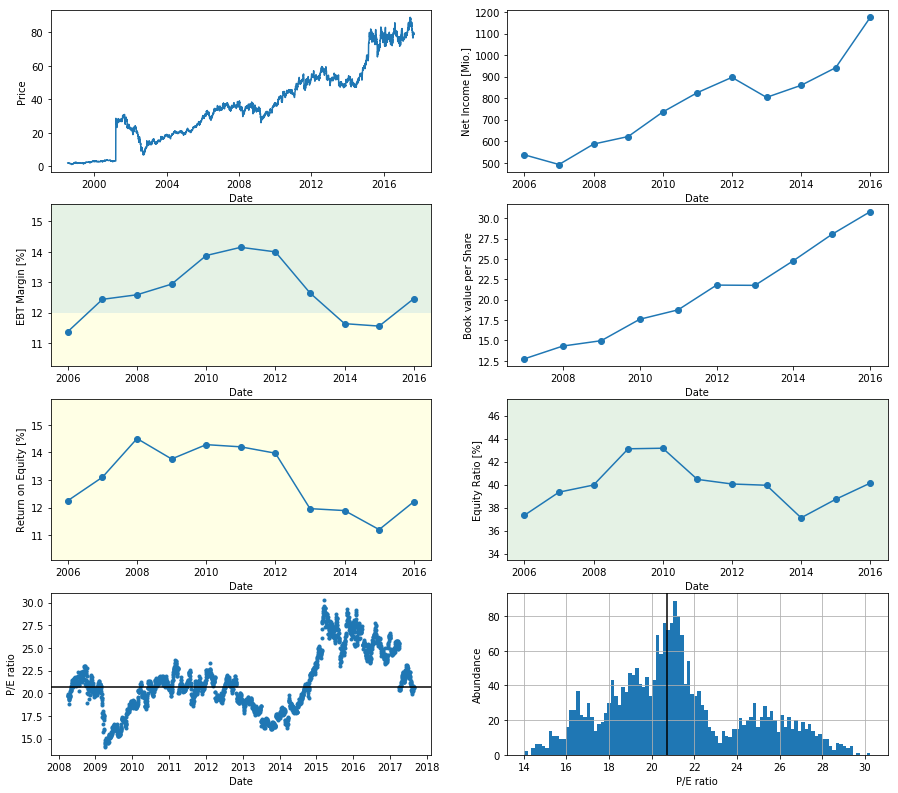

In [294]:
s.plot_summary()

# Calculate maximum drawdown 

In [86]:
s.get_highwatermark()

In [87]:
hwratio = s.quote.close/s.quote.highwatermark

In [88]:
hwratio.describe()

count    4360.000000
mean        0.880524
std         0.132514
min         0.309044
25%         0.843490
50%         0.914717
75%         0.972077
max         1.000000
dtype: float64

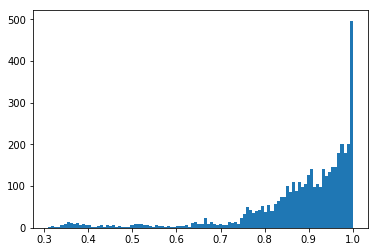

In [89]:
plt.hist(hwratio[hwratio>0],bins=100)
plt.show()

# Backtesting

In [260]:
s.keyratios

,name,ISIN,currency,year,Shares,Revenue,NetIncome,EBTMargin,EarningsPerShare,Dividends,...,FreeCashFlowPerShare,WorkingCapital,COGS,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonInvestedCapital,InterestCoverage
0,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2006,156.0,1323.0,96.0,11.29,0.62,0.13,...,NaN,169.0,64.72,34.94,7.30,1.93,14.08,2.25,29.47,25.10
1,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2007,154.0,1365.0,119.0,13.67,0.77,0.17,...,0.47,154.0,62.70,35.57,8.76,1.96,17.14,2.13,36.08,17.67
2,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2008,147.0,1394.0,109.0,11.68,0.74,0.25,...,0.82,121.0,64.98,32.25,7.85,1.96,15.42,2.24,28.76,21.87
3,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2009,142.0,1178.0,120.0,14.68,0.84,0.27,...,0.41,239.0,61.20,29.79,10.25,1.63,16.67,1.90,27.68,35.58
4,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2010,142.0,1458.0,170.0,16.82,1.20,0.29,...,1.00,286.0,61.13,30.07,11.70,1.78,20.82,1.64,33.91,82.80
5,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2011,142.0,1652.0,182.0,15.73,1.28,0.45,...,0.94,315.0,63.39,29.66,10.93,1.77,19.37,1.51,29.65,97.41
6,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2012,142.0,1819.0,206.0,16.00,1.45,0.50,...,0.82,395.0,63.39,28.86,11.36,1.73,19.69,1.42,28.27,NaN
7,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2013,142.0,1831.0,218.0,16.96,1.53,0.65,...,1.02,426.0,62.33,29.64,11.91,1.61,19.21,1.36,26.45,NaN
8,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2014,139.0,1866.0,220.0,16.62,1.57,0.70,...,1.16,458.0,62.85,29.09,11.76,1.53,18.01,1.40,24.51,NaN
9,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2015,139.0,2079.0,236.0,16.26,1.69,0.77,...,1.58,430.0,61.95,30.22,11.34,1.50,17.05,1.39,23.63,NaN


In [265]:
s.update_time(1120)
print(s.bdate)

2002-04-09


In [266]:
s.keyratios

,name,ISIN,currency,year,Shares,Revenue,NetIncome,EBTMargin,EarningsPerShare,Dividends,...,FreeCashFlowPerShare,WorkingCapital,COGS,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonInvestedCapital,InterestCoverage
16,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2000,NaN,NaN,NaN,NaN,0.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,1999,NaN,NaN,NaN,NaN,0.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
s.update_time(1100)
print(s.bdate)

2002-03-20


In [268]:
s.keyratios

,name,ISIN,currency,year,Shares,Revenue,NetIncome,EBTMargin,EarningsPerShare,Dividends,...,FreeCashFlowPerShare,WorkingCapital,COGS,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonInvestedCapital,InterestCoverage
17,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,1999,NaN,NaN,NaN,NaN,0.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
